Connected to Python 3.12.3

In [ ]:
import sys

import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

#from transformers import CLIPProcessor, CLIPModel

from vit_prisma.utils.data_utils.imagenet.imagenet_utils import imagenet_index_from_word
import numpy as np
import torch as t
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import Callable
from jaxtyping import Float, Int
from torch import Tensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import plotly.express as px
import plotly.io as pio
import einops
import random
import umap.umap_ as umap
import matplotlib.pyplot as plt
from torchvision.datasets import CocoCaptions
from torchvision import transforms
from torch.utils.data import DataLoader
import jax
import torch.nn.functional as f
from matplotlib.colors import ListedColormap
from dotenv import load_dotenv
load_dotenv()  # Load environment variables from .env file
# Set the default renderer for Plotly
pio.renderers.default = "browser"  # or "vscode" or "notebook_connected"
import seaborn as sns
import os
import tqdm
import stat

c:\Users\User\Documents\Cross_modal_interpretability\diagnostic_tool_with_mechinterp\cross_modal_interpretability_env\Lib\site-packages\kaleido\__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
# Set the paths to COCO images and annotation files
#root = os.getenv('DATA_ROOT', '/train2017/train2017')
#annFile = os.getenv('ANN_FILE',"/annotations_trainval2017/annotations/captions_train2017.json")
print("Working Directory:", os.getcwd())
base_dir = os.getenv("directory","")
print(f"Base directory: {base_dir}")
train_path = os.path.join(base_dir, "train2017","train2017")
ann_path = os.path.join(base_dir,"annotations_trainval2017","annotations","captions_train2017.json")
ann_path = os.path.normpath(ann_path)  # Normalize the path to ensure it is correct
print("Full annotation file path:", ann_path)

# Check if train_path exists and is a directory
print("Checking train path...")
print("Exists:", os.path.exists(train_path))
print("Is directory:", os.path.isdir(train_path))
# Check read permissions
print("Readable:", os.access(train_path, os.R_OK))


# Check if ann_path exists and is a file
print("Checking annotation file...")
print("Exists:", os.path.exists(ann_path))
print("Is file:", os.path.isfile(ann_path))

# Check read permissions
print("Readable:", os.access(ann_path, os.R_OK))



# Check file mode and permissions
try:
    file_stat = os.stat(ann_path)
    print("File mode:", oct(file_stat.st_mode))
    print("Owner can read:", bool(file_stat.st_mode & stat.S_IRUSR))
except Exception as e:
    print("Error accessing file stats:", e)


try:
    train_stat = os.stat(train_path)
    print("Train path mode:", oct(train_stat.st_mode))
    print("Owner can read:", bool(train_stat.st_mode & stat.S_IRUSR))
except Exception as e:
    print("Error accessing train path stats:", e)

Working Directory: c:\Users\User\Documents\Cross_modal_interpretability\diagnostic_tool_with_mechinterp
Base directory: C:/Users/User/Documents/Datasets
Full annotation file path: C:\Users\User\Documents\Datasets\annotations_trainval2017\annotations\captions_train2017.json
Checking train path...
Exists: True
Is directory: True
Readable: True
Checking annotation file...
Exists: True
Is file: True
Readable: True
File mode: 0o100666
Owner can read: True
Train path mode: 0o40555
Owner can read: True


In [ ]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [ ]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()

In [ ]:
# We'll use a text-image transformer. Loading the model
from transformers import CLIPProcessor, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print(model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
# Collate function
def coco_collate_fn(batch):
    images,captions = zip(*batch)  # Unzip the batch into images and captions
    images = t.stack(images, dim=0)  # Stack images into a single tensor
    return images, list(captions)  # Return images and captions as a list

# Define image transformations
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure images are in RGB format
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Load the COCO dataset
coco_dataset = CocoCaptions(
    root = train_path,
    annFile = ann_path,
    transform = transform,
)

# Create a DataLoader for the dataset
coco_loader = DataLoader(
    coco_dataset, batch_size=8, shuffle=True, # a batch size of 8 is large enough for vector operations and small enough to fit most GPUs/CPUs
    collate_fn=coco_collate_fn,  # Use the custom collate function
)
# Example: get a batch of images and captions
images, captions = next(iter(coco_loader))  # Return the next iteration of the DataLoader
print("Batch of images:", images)
print("Batch of captions:", captions)
print(f"Shape of images tensor: {images.shape}")  # Should be [batch_size, 3, 224, 224]
print(f"Shape of captions: {len(captions)}")  # Should be the number of captions in the batch


# Get all images and captions from the dataset
#images = []
#captions = []
#for img, cap in zip(coco_loader.dataset, coco_loader.dataset.captions):
#    images.append(img)
#    captions.append(cap)  # Assuming cap is a list of captions, we take the first one
#images = t.stack(images)  # Stack the images into a single tensor
#print(f"Number of total images:{len(images)}\n Shape of images tensor: {images.shape}")

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Batch of images: tensor([[[[0.3686, 0.3804, 0.3882,  ..., 0.2667, 0.2314, 0.2235],
          [0.3804, 0.3922, 0.3922,  ..., 0.2392, 0.2275, 0.2196],
          [0.3961, 0.3882, 0.3961,  ..., 0.2353, 0.2275, 0.2706],
          ...,
          [0.6745, 0.6824, 0.6784,  ..., 0.6745, 0.6667, 0.6549],
          [0.6627, 0.6745, 0.6784,  ..., 0.6667, 0.6627, 0.6549],
          [0.6588, 0.6588, 0.6706,  ..., 0.6627, 0.6588, 0.6510]],

         [[0.4078, 0.4196, 0.4275,  ..., 0.2824, 0.2431, 0.2431],
          [0.4157, 0.4235, 0.4157,  ..., 0.2510, 0.2392, 0.2353],
          [0.4235, 0.4157, 0.4314,  ..., 0.2471, 0.2353, 0.2863],
          ...,
          [0.7020, 0.7020, 0.7059,  ..., 0.6863, 0.6863, 0.6784],
          [0.7098, 0.7020, 0.7020,  ..., 0.6863, 0.6863, 0.6824],
          [0.7059, 0.7059, 0.7098,  ..., 0.6863, 0.6863, 0.6824]],

         [[0.3725, 0.3843, 0.3961,  ..., 0.2510, 0.2196, 0.2118],
        

In [ ]:
# Loading the image
device = "cuda" if t.cuda.is_available() else "cpu"
model = model.to(device)

# Use the batch of images and labels generated earlier
# images: tensor of shape [batch_size, 3, 224, 224] 

# Prepare text and image inputs for the whole batch

# Comparing corresponding captions with the images
first_captions = [cap_list[0] for cap_list in captions]  # Take the first caption for each image
text_inputs = processor(text=first_captions, images=None, return_tensors="pt", padding=True).to(device) 
image_inputs = processor(images=images, return_tensors="pt")
image_inputs["pixel_values"] = image_inputs["pixel_values"].to(device)

with t.no_grad():
    outputs = model(**image_inputs, **text_inputs, output_hidden_states=True)
    image_logits = outputs.logits_per_image  # not per-token logits but computed after the model processes the entire image or text input and prokects them into a shared embedding space
    text_logits = outputs.logits_per_text # not per-token logits but computed after the model processes the entire image or text input and prokects them into a shared embedding space
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()

print("Image Logits:", image_logits)
print("Text Logits:", text_logits)
print("Label probs:", probs)
print(f"Text input IDs: {text_inputs.input_ids}")
print(f"Image logits shape: {image_logits.shape}")
print(f"Text logits shape: {text_logits.shape}")

fig = go.Figure(data=[
    go.Bar(name='Image Logits', x=first_captions, y=image_logits.cpu().numpy().flatten()),
    go.Bar(name='Text Logits', x=first_captions, y=text_logits.cpu().numpy().flatten())
])
fig.update_layout(
    barmode='group',
    title='Image and Text Logits',
    xaxis_title='Labels',
    yaxis_title='Logits'
)
fig.show()

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Image Logits: tensor([[23.4533, 22.9459, 20.3876, 21.1360, 20.0420, 23.6600, 20.8136, 19.6089],
        [23.1725, 22.8083, 20.4958, 20.6652, 20.0281, 23.4770, 20.4627, 20.2057],
        [23.2855, 22.8284, 20.3961, 20.9110, 19.9950, 23.4388, 20.6574, 19.7736],
        [23.4185, 22.9133, 20.4349, 20.7700, 20.2821, 23.4421, 20.5307, 20.2698],
        [23.4089, 23.0008, 20.4305, 20.9999, 20.1702, 23.5844, 20.8118, 19.7968],
        [23.1583, 22.9277, 20.5906, 20.5809, 20.3199, 23.2872, 20.4793, 20.1678],
        [23.2836, 22.6596, 20.5167, 20.7243, 20.3710, 23.0763, 20.4362, 20.2454],
        [23.3989, 22.9884, 20.4546, 20.9577, 20.2850, 23.5233, 20.7749, 19.8966]],
       device='cuda:0')
Text Logits: tensor([[23.4533, 23.1725, 23.2855, 23.4185, 23.4089, 23.1583, 23.2836, 23.3989],
        [22.9459, 22.8083, 22.8284, 22.9133, 23.0008, 22.9277, 22.6596, 22.9884],
        [20.3876, 20.4958, 20.3961, 20.4349, 20.4305, 20.5906, 20.5167, 20.4546],
        [21.1360, 20.6652, 20.9110, 20.7700, 2

In [ ]:
# Get the embeddings
image_embeds = outputs.image_embeds
text_embeds = outputs.text_embeds
print(f"Image Embeddings: {image_embeds.shape}")
print(f"Text Embeddings: {text_embeds.shape}")

Image Embeddings: torch.Size([8, 512])
Text Embeddings: torch.Size([8, 512])


Combined Embeddings Shape: (16, 512)


c:\Users\User\Documents\Cross_modal_interpretability\diagnostic_tool_with_mechinterp\cross_modal_interpretability_env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\User\Documents\Cross_modal_interpretability\diagnostic_tool_with_mechinterp\cross_modal_interpretability_env\Lib\site-packages\umap\umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



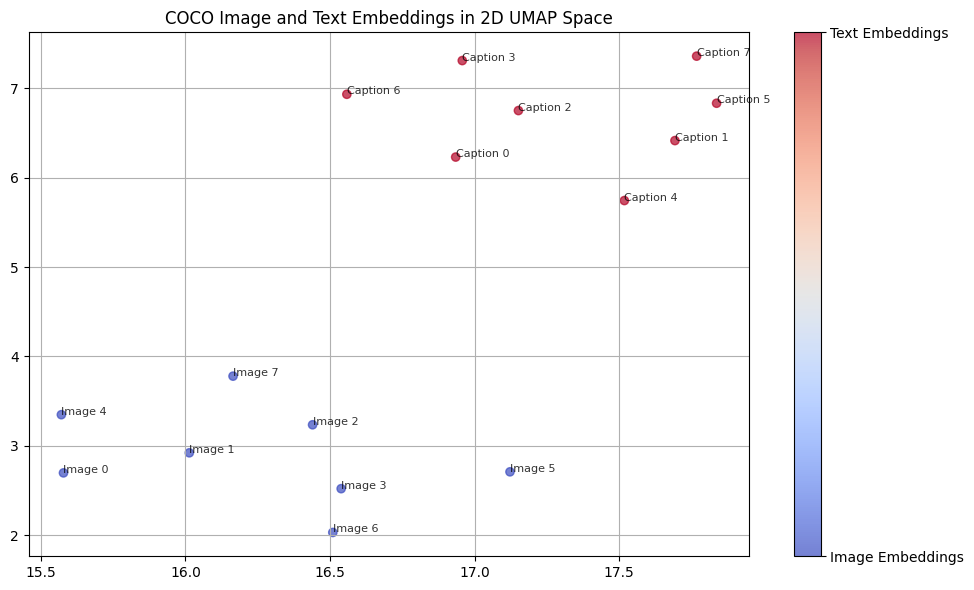

In [ ]:
# Visualise the embeddings in 2-D space using UMAP
text_labels =[f"Caption {i}" for i in range(len(text_embeds))]  # Create unique labels for text embeddings
image_labels = [f"Image {i}" for i in range(len(image_embeds))]  # Create unique labels for image embeddings
cmap = ListedColormap(['steelblue','salmon'])
def plot_embeddings(image_embeds, text_embeds, labels, modality_labels=None, title="Embedding Space"):
    '''
    Plot the embeddings in 2-D space using UMAP.
    Args:
        image_embeds: Image embeddings tensor of shape [batch_size, d_model].
        text_embeds: Text embeddings tensor of shape [batch_size, d_model].
        labels: List of labels for the embeddings.
        modality_labels: List of modality labels for the embeddings (optional).
        title: Title of the plot.
    Returns:
        None
    '''
    assert len(labels) == len(image_embeds) + len(text_embeds), "Labels length must match the number of embeddings"
    combined_embeds = np.vstack([image_embeds,text_embeds])  # Combine image and text embeddings by stacking them vertically
    print(f"Combined Embeddings Shape: {combined_embeds.shape}")
    reducer = umap.UMAP(n_components=2, n_neighbors=50, random_state=0, min_dist=0.1, metric='cosine') # A dimensionality reduction tool, taking higher-dimensional data and projecting it into a lower-dimensional space
    reduced = reducer.fit_transform(combined_embeds) # Used to plot data points on a 2D scatter plot
    assert reduced.shape[1] == 2, f"UMAP failed: expected 2D output, got {reduced.shape[1]}D"
    if reduced.ndim != 2 or reduced.shape[1] != 2:
        raise ValueError(f"Reduced combined embeddings must be 2D for UMAP visualization. Expected 2D embeddings, got shape {reduced.shape}")
    if len(modality_labels) != reduced.shape[0]:
        raise ValueError(f"Label length {len(modality_labels)} does not match the number of embeddings {combined_embeds.shape[0]}")
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=modality_labels,cmap='coolwarm', alpha=0.7)

    for i, label in enumerate(labels):
        plt.annotate(label, (reduced[i, 0], reduced[i, 1]), fontsize=8, alpha=0.8)


    
    plt.title(title)
    cbar = plt.colorbar(scatter, ticks=[0, 1])
    cbar.set_ticks([0, 1])  # Set colorbar ticks
    cbar.set_ticklabels(['Image Embeddings','Text Embeddings'])  # Set colorbar labels
    plt.grid(True)
    plt.tight_layout()
    plt.show()   
# Plot the embeddings
plot_embeddings(
    image_embeds=image_embeds.cpu().numpy(),
    text_embeds=text_embeds.cpu().numpy(),
    labels= image_labels + text_labels,  # Combine text labels and captions for unique labels
    modality_labels= [0] * len(image_embeds) + [1] * len(text_embeds),  # 0 for image embeddings, 1 for text embeddings
    title="COCO Image and Text Embeddings in 2D UMAP Space"
) 

fig = go.Figure(data=[
    go.Bar(name='Image Embeddings', x=image_labels, y=image_embeds.cpu().numpy().mean(axis=1)),
    go.Bar(name='Text Embeddings', x=first_captions, y=text_embeds.cpu().numpy().mean(axis=1))

])
fig.update_layout(
    barmode='group',
    title='Text and Image Embeddings',
    xaxis_title='Labels',
    yaxis_title='Embeddings'
)
fig.show()

In [ ]:
# Cosine similarities for embeddings between each corresponding image and text embeddings (inter-modality)
cosine_similarities = t.cosine_similarity(image_embeds, text_embeds, dim = 1)
print(f"Cosine similarities in the embedding space: {cosine_similarities}")
print(f"Min cosine similarity: {cosine_similarities.min()}")
print(f"Max cosine similarity: {cosine_similarities.max()}")

Cosine similarities in the embedding space: tensor([0.2345, 0.2281, 0.2040, 0.2077, 0.2017, 0.2329, 0.2044, 0.1990],
       device='cuda:0')
Min cosine similarity: 0.19896629452705383
Max cosine similarity: 0.2345333695411682


In [ ]:
# Convert the tensor to a numpy array for plotting

import plotly.express as px
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()

fig = px.bar(
    x = text_labels,
    y = cosine_similarities_np,
    title = "Cosine Similarities between Image and Text Embeddings",
    labels = {'x': 'Text Labels', 'y': 'Cosine Similarities'},
)
fig.show()

In [ ]:
# Similarity matrix for all image-text pairs (inter-modality)
similarity_matrix = t.nn.functional.cosine_similarity(
    image_embeds.unsqueeze(1),  # [batch, 1, d_model]
    text_embeds.unsqueeze(0),   # [1, batch, d_model]
    dim=-1                      # Result: [batch, batch]
)
similarity_matrix_np = similarity_matrix.detach().cpu().numpy()


fig = go.Figure(data=go.Heatmap(
                z=similarity_matrix_np,  # Reshape to 2D for heatmap
                x=text_labels,
                y= image_labels, 
                colorscale='Viridis',
                colorbar=dict(title='Cosine Similarity'),
                zmin=0,zmax=1,  # Set the color scale range
                hoverongaps=False,
                hovertemplate='%{x}: %{y}<br>Cosine Similarity: %{z:.2f}',
                ))
fig.update_layout(
    title="All Pairwise Cosine Similarities Heatmap",
    xaxis_title='Captions',
    yaxis_title='Images',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=100, r=100, t=100, b=100)  # Adjust margins
 )
fig.show()
# similarity_range = cosine_similarities.max() - cosine_similarities.min()
similarity_range = cosine_similarities.max() - cosine_similarities.min()
average_similarity = cosine_similarities.mean()
print(f"Similarity range: {similarity_range}")
print(f"Average similarity: {average_similarity}")
if similarity_range < 0.1 and average_similarity < 0.8:
  print("Poor alignment")

Similarity range: 0.03556707501411438
Average similarity: 0.21402259171009064
Poor alignment


In [ ]:
# Cross-modal cosine similarity matrix (after projection)
# Cosine similarity between projected text and image features
with t.no_grad():
    text_outputs = model.text_model(**text_inputs)
    text_pooled_output = text_outputs.pooler_output
    image_outputs = model.vision_model(**image_inputs)
    image_pool_outputs = image_outputs.pooler_output
text_projected = model.text_projection(text_pooled_output) # [batch, d_model]
image_projected = model.visual_projection(image_pool_outputs) # [batch, d_model]
projected_cosine_similarities = f.cosine_similarity( 
    image_projected.unsqueeze(1) ,  # [batch, 1, d_model]
    text_projected.unsqueeze(0),   # [1, batch, d_model]
    dim=-1                      # Result: [batch, batch]
)
print(f"Projected cosine similarities in the embedding space: {projected_cosine_similarities}")
print (f"Min projected cosine similarity: {projected_cosine_similarities.min()}")
print(f"Max projected cosine similarity: {projected_cosine_similarities.max()}")
print(f" Average projected cosine similarity: {projected_cosine_similarities.mean()}")
go.Figure(data=go.Heatmap(
    z=projected_cosine_similarities.detach().cpu().numpy(),  # Reshape to 2D for heatmap
    x=text_labels,
    y=image_labels, 
    colorscale='Viridis',
    colorbar=dict(title='Projected Cosine Similarity'),
    zmin=0,zmax=1,  # Set the color scale range
    hoverongaps=False,
    hovertemplate='%{x}: %{y}<br>Cosine Similarity: %{z:.2f}',
)).update_layout(
    title="Projected Pairwise Cosine Similarities Heatmap",
    xaxis_title='Captions',
    yaxis_title='Images',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=100, r=100, t=100, b=100)  # Adjust margins
 ).show()

Projected cosine similarities in the embedding space: tensor([[0.2345, 0.2295, 0.2039, 0.2114, 0.2004, 0.2366, 0.2081, 0.1961],
        [0.2317, 0.2281, 0.2050, 0.2067, 0.2003, 0.2348, 0.2046, 0.2021],
        [0.2329, 0.2283, 0.2040, 0.2091, 0.1999, 0.2344, 0.2066, 0.1977],
        [0.2342, 0.2291, 0.2043, 0.2077, 0.2028, 0.2344, 0.2053, 0.2027],
        [0.2341, 0.2300, 0.2043, 0.2100, 0.2017, 0.2358, 0.2081, 0.1980],
        [0.2316, 0.2293, 0.2059, 0.2058, 0.2032, 0.2329, 0.2048, 0.2017],
        [0.2328, 0.2266, 0.2052, 0.2072, 0.2037, 0.2308, 0.2044, 0.2025],
        [0.2340, 0.2299, 0.2045, 0.2096, 0.2028, 0.2352, 0.2077, 0.1990]],
       device='cuda:0', grad_fn=<SumBackward1>)
Min projected cosine similarity: 0.19608891010284424
Max projected cosine similarity: 0.2366003841161728
 Average projected cosine similarity: 0.2146901935338974


In [ ]:
# Class names for the images
# Assuming the first caption corresponds to the first image in the batch
for i,label_indx in enumerate(first_captions):
   class_name = first_captions[i]
   print(f" Image {i}: class name = {class_name}")

 Image 0: class name = A group of people riding skis on top of snow covered slope.
 Image 1: class name = Woman sitting at her computer desk with screen monitor on.
 Image 2: class name = A woman trying to bite a hot dog in a container without holding it. 
 Image 3: class name = A woman is walking with an unusual umbrella.
 Image 4: class name = A woman in white shirt with laptop and ocean in the background.
 Image 5: class name = A baseball player sliding into a base while injuring the baseman.
 Image 6: class name = A woman holding a hot dog next to a man.
 Image 7: class name = A row of vintage cars in a grassy field.


In [ ]:
# Finding the residual directions
# For Images (ViT/CLIP): the residual directions for a class in the column of the classification head weight matrix for that class. 
# For texts (CLIP): the residual direction for a label is the embedding for that label 
normalised_image_residual_directions = f.normalize(model.visual_projection.weight,dim=-1)  # [num_classes, d_model]
print(f"Visual residual directions: {normalised_image_residual_directions.shape}")

normalised_text_residual_directions = f.normalize(model.text_projection.weight,dim=-1)  # [num_classes, d_model]
print(f"Text residual directions: {normalised_text_residual_directions.shape}") 

Visual residual directions: torch.Size([512, 768])
Text residual directions: torch.Size([512, 512])


In [ ]:
# Access the hidden states

vision_hidden_states = outputs.vision_model_output.hidden_states
text_hidden_states = outputs.text_model_output.hidden_states

print("\n--- Vision Model Hidden States ---")
print(f"Type: {type(vision_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(vision_hidden_states)}")

# Get the hidden states from the last layer of the vision model
last_layer_vision_hidden_states = vision_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_vision_hidden_states.shape}")

print("\n--- Text Model Hidden States ---")
print(f"Type: {type(text_hidden_states)}")  # This will be a tuple
print(f"Number of layers (including embeddings): {len(text_hidden_states)}")

# Get the hidden state from the last layer of the text model
last_layer_text_hidden_states = text_hidden_states[-1]
print(f"Shape of the last layer hidden states: {last_layer_text_hidden_states.shape}")

# Get the classification token at the beginning
cls_vision_residual_stream = last_layer_vision_hidden_states[:, 0, :]
cls_text_residual_stream = last_layer_text_hidden_states[:, 0, :]
print(f"Shape of the CLS token in vision model: {cls_vision_residual_stream.shape}")
print(f"Shape of the CLS token in text model: {cls_text_residual_stream.shape}")

# Get CLIP's LayerNorm
vision_ln = model.vision_model.post_layernorm
text_ln = model.text_model.final_layer_norm

# Apply the LayerNorm to the residual streams
scaled_cls_vision = f.normalize(vision_ln(cls_vision_residual_stream),dim=-1)  # Normalize the CLS token for vision
scaled_cls_text = f.normalize(text_ln(cls_text_residual_stream),dim=-1)  # Normalize the CLS token for text

# Print the shapes of the scaled classification tokens
print(f"Scaled CLS Vision shape: {scaled_cls_vision.shape}")
print(f"Scaled CLS Text shape: {scaled_cls_text.shape}")

# Compute logits for each image-text pair in the batch
# image_residual_directions: [batch, d_model] or [d_model]
# text_residual_directions: [batch, d_model] or [d_model]
# If you want to compute the logit for each image-text pair, use einsum over the batch
def compute_dla_logits(scaled_cls_vision, scaled_cls_text, normalised_image_residual_directions, normalised_text_residual_directions):
    """
    Compute the logits for each image-text pair in the batch.
    Args:
        scaled_cls_vision: Scaled CLS token for vision.
        scaled_cls_text: Scaled CLS token for text.
        normalised_image_residual_directions: Normalized residual directions for images.
        normalised_text_residual_directions: Normalized residual directions for text.
    Returns:
        calculated_vision_logit: Logits for vision.
        calculated_text_logit: Logits for text.
    """
    calculated_vision_logit = einsum('b d,c d-> b c', scaled_cls_vision, normalised_image_residual_directions)  # Each image projected onto each of the 512 class directions
    calculated_text_logit = einsum('b d, c d -> b c', scaled_cls_text, normalised_text_residual_directions)  # Each image projected onto each of the 512 class directions
    print(f"Vision logit shape: {calculated_vision_logit.shape}")
    print(f"Text logit shape: {calculated_text_logit.shape}")
    return calculated_vision_logit, calculated_text_logit
vision_logit, text_logit = compute_dla_logits(
    scaled_cls_vision,
    scaled_cls_text,
    normalised_image_residual_directions,
    normalised_text_residual_directions
)

# Add the bias for each class to the vision and text logits if present
if getattr(model.visual_projection, 'bias', None) is not None:
    assert model.visual_projection.bias.shape == vision_logit.shape
    vision_logit += model.visual_projection.bias
else:
    print("No bias in the visual projection layer.")

if getattr(model.text_projection, 'bias', None) is not None:
    assert model.text_projection.bias.shape == text_logit.shape
    text_logit += model.text_projection.bias
else:
    print("No bias in the text projection layer.")

# Print the logits for the batch
# Batched retrieval with 8 images and 8 prompts
for i in range(len(vision_logit)):
    for j in range(len(text_logit)):
    
        print(f"Image {i}, Class {j}: Vision Logit: {round(vision_logit[i][j].item(),3)}, Text Logit: {round(text_logit[j][i].item(),3)}", # image i projected to prompt j direction
              f" Vision logit from model: {round(image_logits[i][j].item(),3)}, Text logit from model: {round(text_logits[j][i].item(),3)}") # prompt j projected to image i direction

pio.renderers.default = "browser"
import plotly.graph_objs as go

sim_matrix = t.mm(f.normalize(scaled_cls_text, dim=-1), f.normalize(scaled_cls_text, dim=-1).T)  # Cosine similarity matrix
print("Text CLS cosine similarity matrix :\n", sim_matrix)
# Prepare unique labels for each image

# Convert logits to numpy for plotting
vision_logit_np = vision_logit.detach().cpu().numpy()
text_logit_np = text_logit.detach().cpu().numpy()
vision_logit_diag = [vision_logit_np[i,i] for i in range(len(vision_logit_np))]  # Image i logit for prompt i
text_logit_diag = [text_logit_np[i,i] for i in range(len(text_logit_np))]  # prompt i logit for image i
# Create a grouped bar chart for direct logit attributions
fig = go.Figure(data=[
    go.Bar(name='Vision Logit', x=image_labels, y=vision_logit_diag),
    go.Bar(name='Text Logit', x=text_labels, y=text_logit_diag)
])

fig.update_layout(
    barmode='group',
    title='Direct Logit Attributions per Image',
    xaxis_title='Text Labels (Image Index)',
    yaxis_title='Logit Value'
)

fig.show()


--- Vision Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 50, 768])

--- Text Model Hidden States ---
Type: <class 'tuple'>
Number of layers (including embeddings): 13
Shape of the last layer hidden states: torch.Size([8, 17, 512])
Shape of the CLS token in vision model: torch.Size([8, 768])
Shape of the CLS token in text model: torch.Size([8, 512])
Scaled CLS Vision shape: torch.Size([8, 768])
Scaled CLS Text shape: torch.Size([8, 512])
Vision logit shape: torch.Size([8, 512])
Text logit shape: torch.Size([8, 512])
No bias in the visual projection layer.
No bias in the text projection layer.
Image 0, Class 0: Vision Logit: -0.017, Text Logit: 0.003  Vision logit from model: 23.453, Text logit from model: 23.453
Image 0, Class 1: Vision Logit: -0.028, Text Logit: 0.003  Vision logit from model: 22.946, Text logit from model: 22.946
Image 0, Class 2: Vision Logit: -0.06, Text Logit: 0.003  

In [ ]:
# Investigate preprocessed tokens 
# Freeze the tokenizer pipeline
logit_scale = model.logit_scale

logits = logit_scale * image_projected @ text_projected.T
print(logits)

tensor([[ 89.9139,  95.4035,  82.9446,  87.9278,  69.0296, 105.4354,  89.9225,
          77.5257],
        [ 89.5930,  95.6380,  84.0942,  86.7005,  69.5688, 105.5098,  89.1587,
          80.5649],
        [ 89.5898,  95.2545,  83.2764,  87.3031,  69.1141, 104.8232,  89.5669,
          78.4567],
        [ 90.8740,  96.4285,  84.1497,  87.4579,  70.7078, 105.7367,  89.7808,
          81.1149],
        [ 90.2027,  96.1209,  83.5443,  87.8083,  69.8266, 105.6362,  90.3745,
          78.6693],
        [ 90.5384,  97.2130,  85.4270,  87.3115,  71.3707, 105.8263,  90.2276,
          81.3122],
        [ 91.7579,  96.8461,  85.8026,  88.6244,  72.1239, 105.7084,  90.7595,
          82.2792],
        [ 89.8654,  95.7508,  83.3660,  87.3417,  69.9914, 105.0130,  89.9154,
          78.8037]], device='cuda:0', grad_fn=<MmBackward0>)


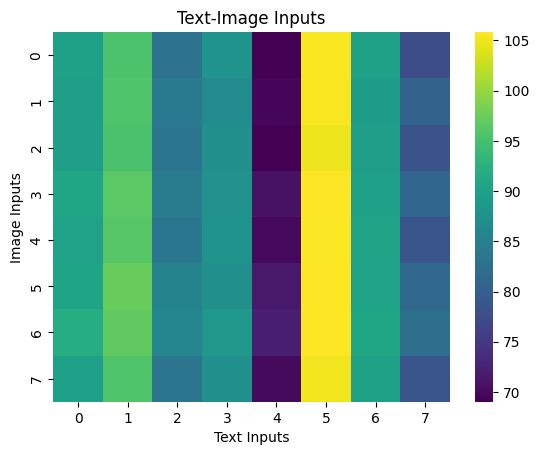

In [ ]:
# Logit-level diagnostic matrix
sns.heatmap(logits.detach().cpu().numpy(), cmap='viridis')
plt.title("Text-Image Inputs")
plt.xlabel("Text Inputs")
plt.ylabel("Image Inputs")
plt.show()

In [ ]:
# Average projected text and image features
print("Average projected text features:", text_projected.mean(dim=0))
print("Average projected image features:", image_projected.mean(dim=0))

# Cosine similarity between average projected text and image features
avg_projected_cosine_similarity = f.cosine_similarity(
    image_projected.mean(dim=0, keepdim=True),  # [1, d_model]
    text_projected.mean(dim=0, keepdim=True),   # [1, d_model]
    dim=-1                      # Result: [1]
)
print(f"Average projected cosine similarity: {round(avg_projected_cosine_similarity.item(),3)}")

# L2 distance between average projected text and image features
avg_projected_l2_distance = t.norm(
    image_projected.mean(dim=0)- text_projected.mean(dim=0)
)
print(f"Average projected L2 distance: {round(avg_projected_l2_distance.item(),3)}")

Average projected text features: tensor([ 1.9573e-02,  4.0755e-04, -2.1760e-01,  8.6976e-02,  3.2120e-02,
         1.1216e-01, -9.0391e-02, -1.2151e-01, -1.3334e-01,  3.6319e-02,
         1.0253e-01, -9.4991e-02,  3.8941e-01, -5.1306e-02,  5.1523e-02,
         1.0802e-01, -2.4781e-01,  4.5812e-02, -9.7437e-03,  1.6851e-01,
         1.5700e-01,  2.8660e-01, -3.9774e-02, -1.0565e-01, -3.4558e-02,
        -1.0438e-01,  1.7228e-02,  6.9371e-03,  2.9182e-02, -3.5386e-02,
         6.6520e-02, -5.3211e-02, -1.1490e-02, -8.6670e-02, -2.5152e-01,
        -1.9988e-01,  7.7614e-02,  1.0059e-01, -1.4345e-01,  8.0171e-02,
        -2.8406e-02,  2.4639e-02,  2.3247e-02,  9.2247e-02,  2.5768e-01,
         2.1032e-01,  1.7926e-01,  2.8834e-02, -6.7416e-02, -1.8470e-01,
        -4.7579e-03,  3.8400e-02,  3.9065e-02,  3.0122e-02, -1.6033e-01,
        -1.1915e-01,  1.9404e-01,  1.4927e-01, -1.1278e-01,  1.5286e-01,
         1.1231e-01, -1.5748e-01,  1.0286e-02,  2.6450e-02,  1.6035e-02,
        -3.7314e-0

In [ ]:
# Check for LayerNorm
vis_projection = model.visual_projection
text_projection = model.text_projection
for name,module in vis_projection.named_modules():
    if isinstance(module, t.nn.LayerNorm):
        print(f"LayerNorm found in visual projection: {name} with normalised shape {module.normalized_shape}")
    else:
        print(f"LayerNorm not found in visual projection")
for name,module in text_projection.named_modules():
    if isinstance(module, t.nn.LayerNorm):
        print(f"LayerNorm found in text projection: {name} with normalised shape {module.normalized_shape}")
    else:
        print(f"LayerNorm not found in text projection")

with t.no_grad():
    text_outputs = model.text_model(**text_inputs)
    text_pooled_output = text_outputs.pooler_output
    image_outputs = model.vision_model(**image_inputs)
    image_pool_outputs = image_outputs.pooler_output
    projected_vision_embeds = model.text_projection(text_pooled_output) # [batch, d_model]
    projected_text_embeds = model.visual_projection(image_pool_outputs) # [batch, d_model]
    text_sd = projected_text_embeds.std()
    vision_sd = projected_vision_embeds.std()
    text_mean = projected_text_embeds.mean()
    vision_mean = projected_vision_embeds.mean()
    print(f"Text projection standard deviation: {text_sd.item():.4f}")
    print(f"Vision projection standard deviation: {vision_sd.item():.4f}")
    print(f"Text projection mean: {text_mean.item():.4f}")
    print(f"Vision projection mean: {vision_mean.item():.4f}")

# Check norm inflation
# Check weight statistics
text_projected_weight = model.text_projection.weight
vision_projected_weight = model.visual_projection.weight
#print(f"Text projection weight shape: {text_projected_weight.shape}")
#print(f"Vision projection weight shape: {vision_projected_weight.shape}")
norm_text_projected_weight = t.norm(text_projected_weight, dim=1)  # L2 norm over the last dimension
norm_vision_projected_weight = t.norm(vision_projected_weight, dim=1)
print(f"Mean text projection weight norm: {norm_text_projected_weight.mean().item():.4f}")
print (f"Max text projection weight norm: {norm_text_projected_weight.max().item():.4f}")
print(f"Mean vision projection weight norm: {norm_vision_projected_weight.mean().item():.4f}")
print (f"Max vision projection weight norm: {norm_vision_projected_weight.max().item():.4f}")
# Check norm over training
text_projected_norm = t.norm(projected_text_embeds, dim=-1)  # L2 norm over the last dimension
vision_projected_norm = t.norm(projected_vision_embeds, dim=-1)
print(f"Mean text projected norm: {text_projected_norm.mean().item():.4f}")
print(f"Mean vision projected norm: {vision_projected_norm.mean().item():.4f}")
# Check feature dominance 
var_text_dimwise = t.var(projected_text_embeds, dim=0) # Variance along the text feature dimension
var_visual_dimwise = t.var(projected_vision_embeds, dim=0) # Variance along the visual feature dimension
text_top_k = t.topk(var_text_dimwise, k=10) # Get the top 10 features with highest variance
var_visual_dimwise = t.var(projected_vision_embeds, dim=0) # Variance along the feature dimension
vision_top_k = t.topk(var_visual_dimwise, k=10) # Get the
rounded_text_top_k = text_top_k.values.round(decimals=4).cpu().numpy()  # Round the values to 4 decimal places
rounded_vision_top_k = vision_top_k.values.round(decimals=4).cpu().numpy()  # Round the values to 4 decimal places
print(f"Top 10 text dominant dimensions: {text_top_k.indices.tolist()}")
print (f"Top 10 text values : {rounded_text_top_k}")
print(f"Top 10 vision dominant dimensions: {vision_top_k.indices.tolist()}")
print (f"Top 10 vision values : {rounded_vision_top_k}")

LayerNorm not found in visual projection
LayerNorm not found in text projection
Text projection standard deviation: 0.5117
Vision projection standard deviation: 0.3395
Text projection mean: -0.0120
Vision projection mean: 0.0146
Mean text projection weight norm: 0.2920
Max text projection weight norm: 0.5481
Mean vision projection weight norm: 0.3524
Max vision projection weight norm: 0.9038
Mean text projected norm: 11.5796
Mean vision projected norm: 7.6684
Top 10 text dominant dimensions: [92, 106, 45, 263, 39, 286, 428, 357, 389, 93]
Top 10 text values : [0.0201 0.016  0.0134 0.0106 0.0104 0.0076 0.0073 0.0064 0.0055 0.0054]
Top 10 vision dominant dimensions: [133, 312, 67, 423, 178, 319, 329, 350, 220, 295]
Top 10 vision values : [0.7406 0.7377 0.3817 0.2832 0.2817 0.197  0.1834 0.1786 0.174  0.1655]


In [ ]:
# Pre-projected text and image embeddings' L2 norms
pre_text_l2_norms = t.norm(text_embeds, dim=-1)
pre_vision_l2_norms = t.norm(image_embeds, dim=-1)

# Post-projected text and image embeddings' L2 norms
post_text_l2_norms = t.norm(projected_text_embeds, dim=-1)
post_vision_l2_norms = t.norm(projected_vision_embeds, dim=-1)

# Print the L2 norms
print(f"Pre-projected mean text L2 norms: {pre_text_l2_norms.mean().item():0.4f}\n Pre-projected  mean vision L2 norms: {pre_vision_l2_norms.mean().item():0.4f}")
print(f"Post-projected mean text L2 norms: {post_text_l2_norms.mean().item():0.4f}\n Post-projected mean vision L2 norms: {post_vision_l2_norms.mean().item():0.4f}")

Pre-projected mean text L2 norms: 1.0000
 Pre-projected  mean vision L2 norms: 1.0000
Post-projected mean text L2 norms: 11.5796
 Post-projected mean vision L2 norms: 7.6684


Normalising L2 norms for CLIP...
Normalised text projected shape: torch.Size([8, 512])
Normalised vision projected shape: torch.Size([8, 512])
Combined Embeddings Shape: (16, 512)


c:\Users\User\Documents\Cross_modal_interpretability\diagnostic_tool_with_mechinterp\cross_modal_interpretability_env\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\User\Documents\Cross_modal_interpretability\diagnostic_tool_with_mechinterp\cross_modal_interpretability_env\Lib\site-packages\umap\umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



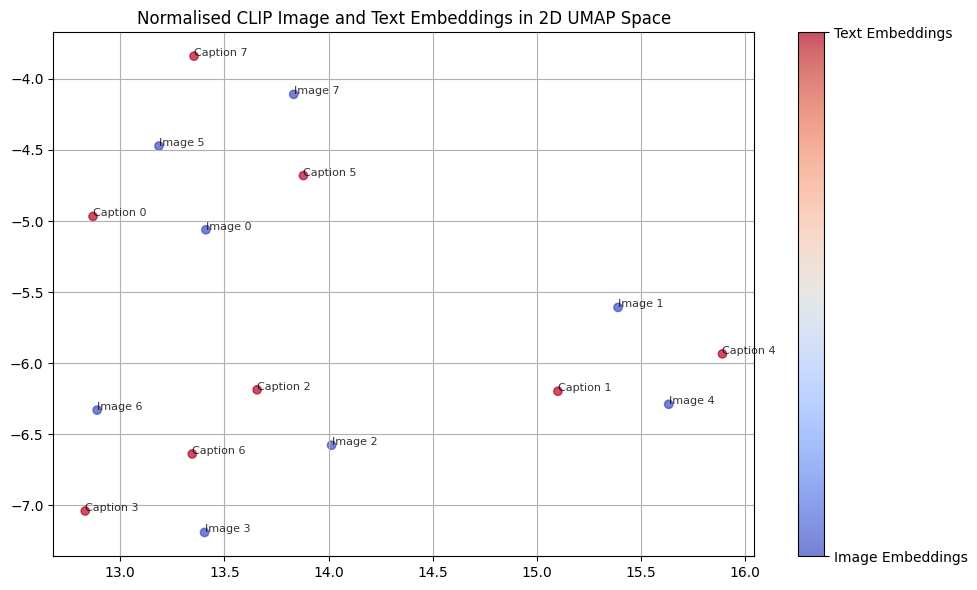

In [ ]:
def normalise_l2(name, text_projected, vision_projected):
    """
    Normalise the L2 norms of the projected text and vision embeddings.
    Args:
        name: Name of the model.
        text_projected: Projected text embeddings.
        vision_projected: Projected vision embeddings.
    Returns:
        None
    """
    print(f"Normalising L2 norms for {name}...")
    text_norm = t.norm(text_projected, dim=-1, keepdim=True)
    vision_norm = t.norm(vision_projected, dim=-1, keepdim=True)
    text_projected /= text_norm
    vision_projected /= vision_norm
    print(f"Normalised text projected shape: {text_projected.shape}")
    print(f"Normalised vision projected shape: {vision_projected.shape}")
    return text_projected, vision_projected
normalised_text_projected, normalised_vision_projected = normalise_l2('CLIP', projected_text_embeds, projected_vision_embeds) 
plot_embeddings(
    image_embeds=normalised_vision_projected.cpu().numpy(),
    text_embeds=normalised_vision_projected.cpu().numpy(),
    labels=image_labels + text_labels,  # Combine text labels and captions for unique labels
    modality_labels=[0] * len(normalised_vision_projected) + [1] * len(normalised_text_projected),  # 0 for image embeddings, 1 for text embeddings
    title="Normalised CLIP Image and Text Embeddings in 2D UMAP Space"
    
)

In [ ]:
# Caching all activations
from vit_prisma.prisma_tools import activation_cache
from vit_prisma.models.model_loader import load_hooked_model

model_name = "open-clip:laion/CLIP-ViT-B-16-DataComp.L-s1B-b8K"
clip_model = load_hooked_model(model_name)
clip_model.to('cuda') # Move to cuda if available
#clip_images = einops.rearrange(images, 'b c h w -> b h w c')
clip_image_logits, clip_image_cache = clip_model.run_with_cache(
    input = image_inputs["pixel_values"],
    return_cache_object=True,
    remove_batch_dim=True,  # Remove batch dimension for simplicity
)
print(type(clip_image_logits), type(clip_image_cache))

<class 'torch.Tensor'> <class 'vit_prisma.prisma_tools.activation_cache.ActivationCache'>


In [ ]:
# Accessing attention patterns from the first layer
attn_patterns_from_shorthand = clip_image_cache["pattern",0]
attn_patterns_from_full_name = clip_image_cache["blocks.0.attn.hook_pattern"]
print(f"Attention patterns from shorthand: {attn_patterns_from_shorthand.shape}")
print(f"Attention patterns from full name: {attn_patterns_from_full_name.shape}")
act_names = prisma_utils.get_act_name("pattern", 0)  # Get the names of the activations
print(f"Activation names: {act_names}")

Attention patterns from shorthand: torch.Size([12, 197, 197])
Attention patterns from full name: torch.Size([12, 197, 197])
Activation names: blocks.0.attn.hook_pattern


In [ ]:
# Verifying that hook_q, hook_k and hook_pattern are related to each other 
layer_0_pattern_from_cache = clip_image_cache["pattern",0]
hook_q = clip_image_cache["q",0]  # Accessing the hook_q for the first layer
hook_k = clip_image_cache["k",0]
# Check the shapes of the hooks


print(f"Shape of hook_q: {hook_q.shape}")

print(f"Shape of hook_k: {hook_k.shape}")
s,n,d = hook_q.shape
device = hook_q.device
attn_scores = einops.einsum(hook_q, hook_k, 's n h, t n h -> n s t')
# Note: Since CLIP or any other ViT-based models use bidirectional self-attention, we do not apply causal masking (autoaggressive masking) because the model can see the entire sequence, not just the one that comes before.
attn_scores = attn_scores/(d ** 0.5)  # Scale the attention scores
layer_0_pattern_from_q_k = attn_scores.softmax(-1)  # Softmax over the last dimension to get the attention pattern
print(f"Shape of layer 0 pattern from cache: {layer_0_pattern_from_cache.shape}")
print(f"Shape of attention scores from q and k: {layer_0_pattern_from_q_k.shape}")
t.testing.assert_close(layer_0_pattern_from_cache, layer_0_pattern_from_q_k)  # Check if they are numerically close to each other
print("The attention patterns from cache and from q and k are numerically close to each other.")

Shape of hook_q: torch.Size([197, 12, 64])
Shape of hook_k: torch.Size([197, 12, 64])
Shape of layer 0 pattern from cache: torch.Size([12, 197, 197])
Shape of attention scores from q and k: torch.Size([12, 197, 197])
The attention patterns from cache and from q and k are numerically close to each other.


In [ ]:
def visualise_attention(
        heads,
        local_cache,
        title,
        max_width,
        batch_idx,
        attention_type="attn_scores",

) -> str:
    '''
    Visualise attention patterns for a given set of heads.
    Args:
        heads: List of attention head indices or a single index.
        label: List of labels for the heads.
        patterns: List of attention patterns for the heads.
    Returns:
        patterns: A tensor of attention patterns for the heads.
    '''
    if isinstance(heads,int):
        head = [heads]
    # Create the plotting data
    label: List[str] = []
    patterns: List[Float[t.Tensor,"dest ps src_pos"]] = []
    for head in heads:
        # Set the label
        layer = head // clip_model.cfg.n_heads
        head_idx = head % clip_model.cfg.n_heads
        label.append(f"Layer {layer} Head {head_idx}")
        # Get the attention patterns for the head
        patterns.append(local_cache[attention_type, layer][batch_idx,head_idx])
    # Combine the patterns into a single tensor
    patterns = t.stack(patterns, dim=0)  # [heads, dest, src]
    return patterns

def get_attn_across_datapoints(attn_head_idx, attn_type="attn_scores"):
    '''
    Obtain attention patterns across all datapoints for a given attention head.
    Args:
        list_of_attn_heads: List of attention head indices.
        all_patterns: List of attention patterns for the heads.
    Returns:
        all_patterns: A tensor of attention patterns for the heads across all datapoints.
    '''
    list_of_attn_heads = [attn_head_idx]

    all_patterns = []
    for batch_idx in range(images.shape[0]):
        patterns = visualise_attention(
            list_of_attn_heads, clip_image_cache, "Attention Patterns", 700, batch_idx, attention_type=attn_type),
        all_patterns.extend(patterns) # Adding to the end of the list
    all_patterns = t.stack(all_patterns, dim=0)  # [batch, heads, dest, src]
    return all_patterns

# Set global seeds
def set_global_seeds(seed_value: int):
    '''
    Set global seeds for reproducibility.
    Args:
        seed_value: The seed value to set.
    Returns:
        None
    '''
    t.manual_seed(seed_value)
    t.cuda.manual_seed(seed_value)
    t.cuda.manual_seed_all(seed_value)  # For multi-GPU setups
    np.random.seed(seed_value) # For NumPy operations
    random.seed(seed_value)  # For Python's random module
    t.backends.cudnn.benchmark = False  # Disable CuDNN benchmarking for reproducibility
    t.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

seed_value = 42  # Set your desired seed value
set_global_seeds(seed_value)
# Define a worker init function that sets the seed
def worker_init_fn(worker_id):
    '''
    Worker init function for DataLoader.
    Args:
        worker_id: The ID of the worker.
    Returns:
        None
    '''
    worker_seed = t.initial_seed() % 2**32 # Ensuring that the worker seed is a valid 32-bit integer (within the range of a 32-bit unsigned integer (0 to 2^(32-1)))
    np.random.seed(worker_seed)  # Set the seed for NumPy operations in the worker
    random.seed(worker_seed)  # Set the seed for Python's random module in the worker

Shape of cache: torch.Size([12, 197, 197])
Shape of attention for layer 0, head 0: torch.Size([197, 197])
Shape of attention for layer 0, head 1: torch.Size([197, 197])
Shape of attention for layer 0, head 2: torch.Size([197, 197])
Shape of attention for layer 0, head 3: torch.Size([197, 197])
Shape of attention for layer 0, head 4: torch.Size([197, 197])
Shape of attention for layer 0, head 5: torch.Size([197, 197])
Shape of attention for layer 0, head 6: torch.Size([197, 197])
Shape of attention for layer 0, head 7: torch.Size([197, 197])
Shape of attention for layer 0, head 8: torch.Size([197, 197])
Shape of attention for layer 0, head 9: torch.Size([197, 197])
Shape of attention for layer 0, head 10: torch.Size([197, 197])
Shape of attention for layer 0, head 11: torch.Size([197, 197])
Shape of attention for layer 1, head 0: torch.Size([197, 197])
Shape of attention for layer 1, head 1: torch.Size([197, 197])
Shape of attention for layer 1, head 2: torch.Size([197, 197])
Shape of a

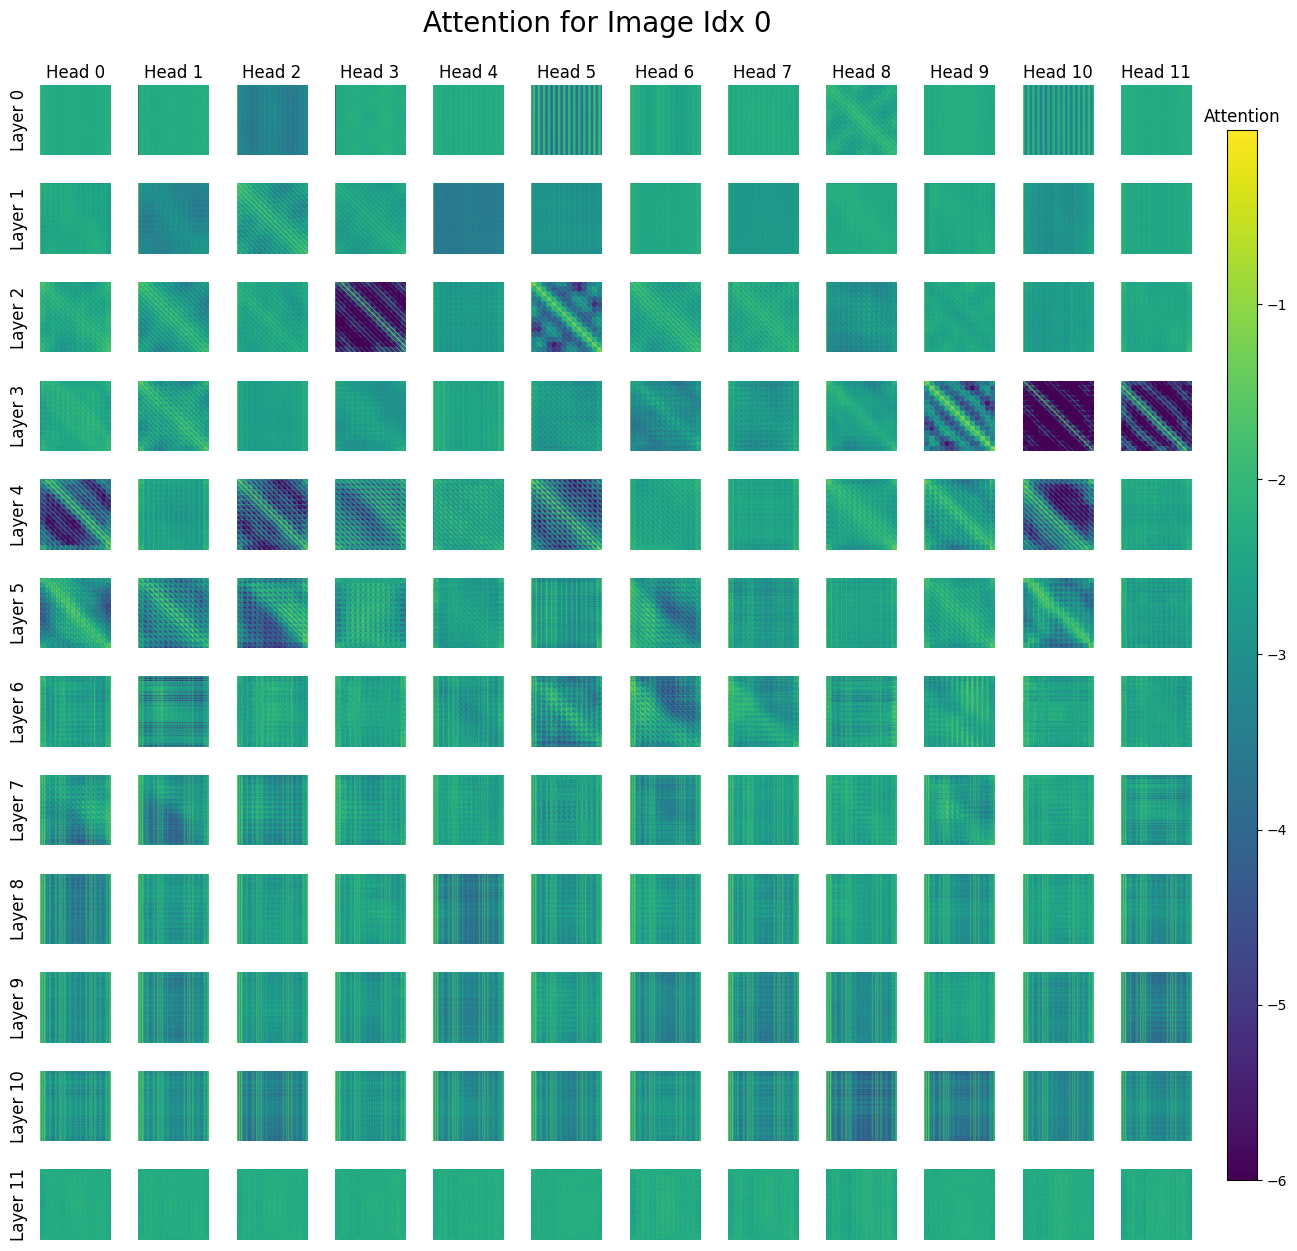

In [ ]:
from vit_prisma.visualization.visualize_attention import plot_attn_heads
# Visualising all 12 heads 
print(f"Shape of cache: {attn_patterns_from_shorthand.shape}")  # Should be [batch, heads, dest, src]
all_attentions = []
#BATCH_IDX = 0  # Index of the batch to visualize
for layer_idx in range(clip_model.cfg.n_layers):
    for head_idx in range(clip_model.cfg.n_heads):
        attn = clip_image_cache["pattern",layer_idx][head_idx,:,:]  # Accessing the attention pattern for the specific layer and head. No need for batch index since there are no batches in the cache
        print(f"Shape of attention for layer {layer_idx}, head {head_idx}: {attn.shape}")
        all_attentions.append(attn)
all_attentions = t.stack(all_attentions, dim=0)
all_attentions = all_attentions.cpu().numpy()  # Move to CPU for visualization
print(f"Shape of all attentions: {all_attentions.shape}")  # [heads, dest, src]
plot_attn_heads(
    total_activations=all_attentions,
    n_heads=clip_model.cfg.n_heads,  # Number of attention heads
    n_layers=clip_model.cfg.n_layers,  # Number of layers
    global_min_max= True,  # Use global min-max scaling for all heads
    img_shape=all_attentions.shape[-1],  # Assuming square attention maps
    figsize=(15, 15),  # Set the figure size
    global_normalize=False,
    log_transform=True,
)